In [13]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
# Parameters
noise_levels = np.linspace(0.01, 0.10, 5)
samples_per_level = 200

data, labels, noise_list = [], [], []

for p in noise_levels:
    for _ in range(samples_per_level):
        # Simulate fidelity in [0,1] with spread around (1-p)
        fidelity = np.clip((1 - p) + np.random.randn()*0.1, 0.0, 1.0)
        # Force roughly half above/below 0.8
        label = int(fidelity >= 0.8)
        # Tilt some fidelities below threshold even at low noise
        if np.random.rand() < 0.3:
            fidelity = np.random.rand()*0.7  # ensure some low fidelities
            label = 0

        alpha_other = max((1 - fidelity)*10, 0.1)
        alpha_target = max(fidelity*50, 0.1)
        probs = np.random.dirichlet([alpha_other]*3 + [alpha_target])

        data.append(probs)
        labels.append(label)
        noise_list.append(p)

X = np.array(data)
y = np.array(labels)
noise_list = np.array(noise_list)
print(f"Dataset shape: {X.shape}, Class distribution: {np.bincount(y)}")

Dataset shape: (1000, 4), Class distribution: [360 640]


In [15]:
X_train, X_test, y_train, y_test, noise_train, noise_test = train_test_split(
    X, y, noise_list, test_size=0.3, random_state=42
)

clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Test Accuracy: 0.94


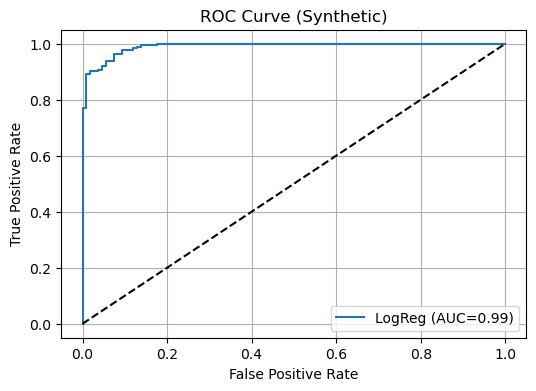

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'LogReg (AUC={roc_auc:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Synthetic)')
plt.legend()
plt.grid(True)
plt.savefig('roc_curve.png', dpi=300)
plt.show()

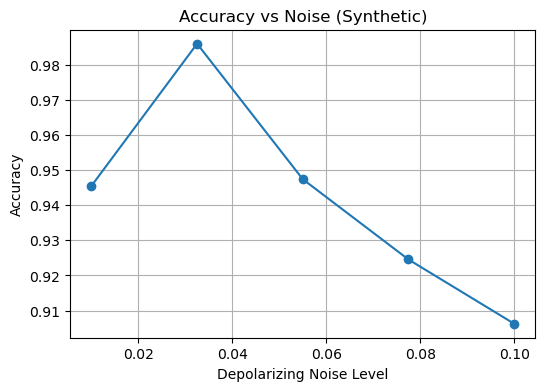

In [17]:
noise_vals = sorted(np.unique(noise_test))
acc_vs_noise = [
    accuracy_score(y_test[noise_test==p], y_pred[noise_test==p])
    for p in noise_vals
]

plt.figure(figsize=(6,4))
plt.plot(noise_vals, acc_vs_noise, 'o-')
plt.xlabel('Depolarizing Noise Level')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Noise (Synthetic)')
plt.grid(True)
plt.savefig('accuracy_vs_noise.png', dpi=300)
plt.show()